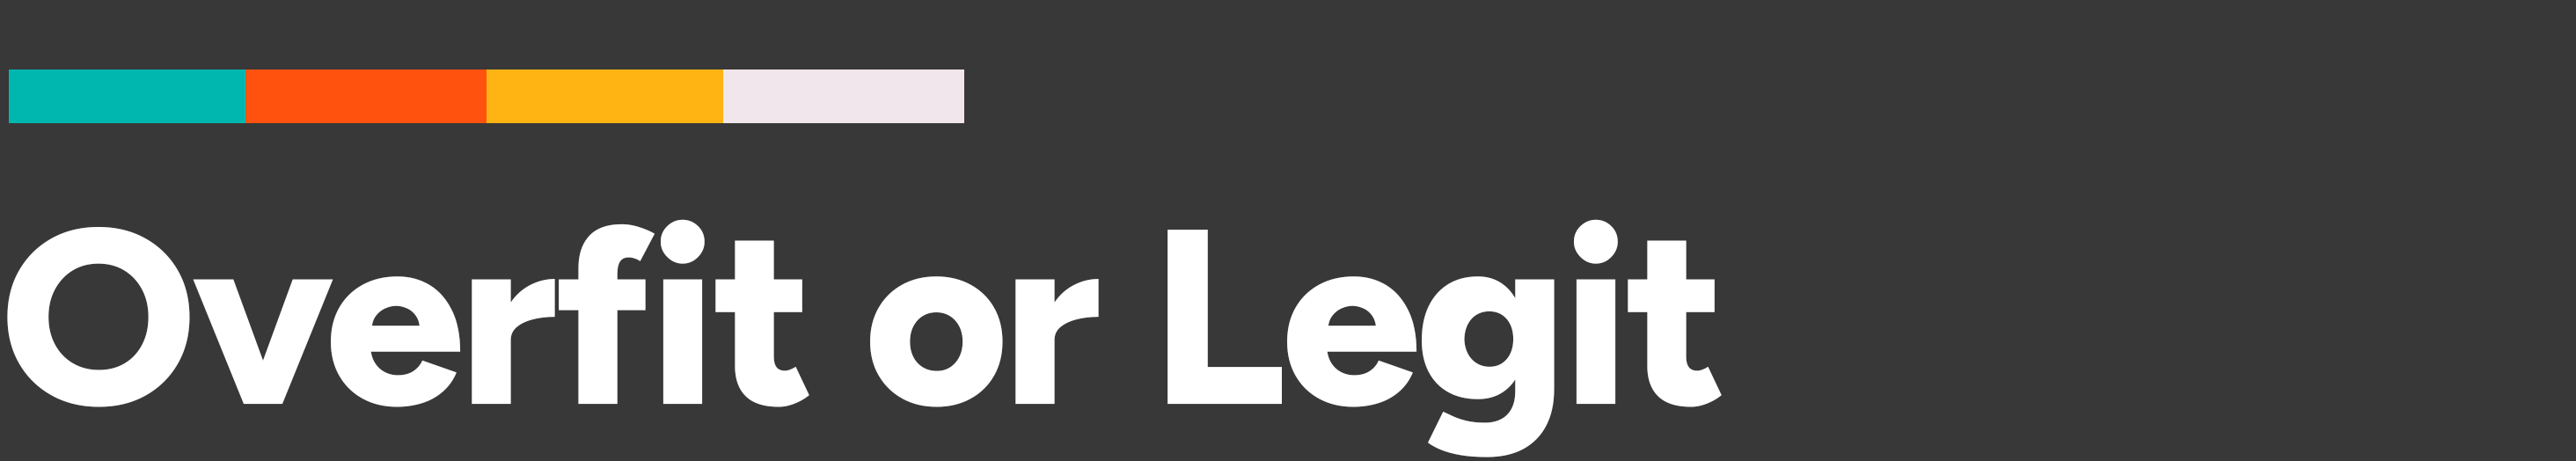

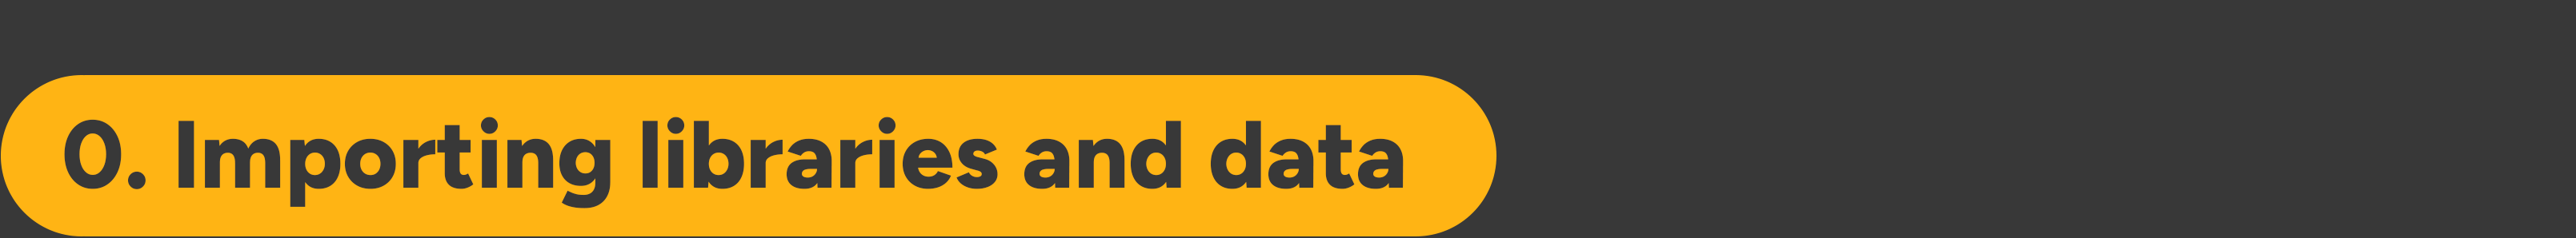

In [3]:
import glob
import os
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import ta
from statsmodels.tsa.stattools import adfuller, kpss
from tsfracdiff import FractionalDifferentiator
from hmmlearn import hmm

sns.set(style='dark', palette='viridis')

In [ ]:
drive.mount('/content/drive')
directory_path = (
    '/content/drive/MyDrive/1. learning/1datasci/'
    '🌸 project 1. backtest overfitting forex/forex_data_lite'
)
files = glob.glob(os.path.join(directory_path, '*.csv'))

forex = pd.DataFrame()
content = []
for i in files:
    df = pd.read_csv(i, index_col='Date', header=0)
    content.append(df)

forex = pd.concat(content, axis=1)
forex.dropna(inplace=True)
forex.index = pd.to_datetime(forex.index)

forex

Mounted at /content/drive


,NZDJPY,USDNOK,AUDJPY,GBPSGD,CADJPY,EURJPY,XAGUSD,AUDCHF
Date,,,,,,,,
2013-03-18 22:05:00,78.817,5.79210,99.159,1.88498,93.246,123.528,28.950,0.98401
2013-03-18 22:10:00,78.815,5.79153,99.167,1.88536,93.245,123.507,28.947,0.98431
2013-03-18 22:15:00,78.810,5.79213,99.157,1.88551,93.231,123.536,28.956,0.98440
2013-03-18 22:20:00,78.822,5.79259,99.182,1.88563,93.206,123.531,28.970,0.98448
2013-03-18 22:25:00,78.853,5.79234,99.229,1.88564,93.179,123.589,28.963,0.98445
...,...,...,...,...,...,...,...,...
2024-05-07 10:05:00,92.828,10.86585,101.990,1.69644,112.977,166.347,27.204,0.59906
2024-05-07 10:10:00,92.822,10.86554,101.995,1.69645,112.965,166.364,27.205,0.59900
2024-05-07 10:15:00,92.828,10.86469,102.016,1.69645,112.973,166.376,27.194,0.59904


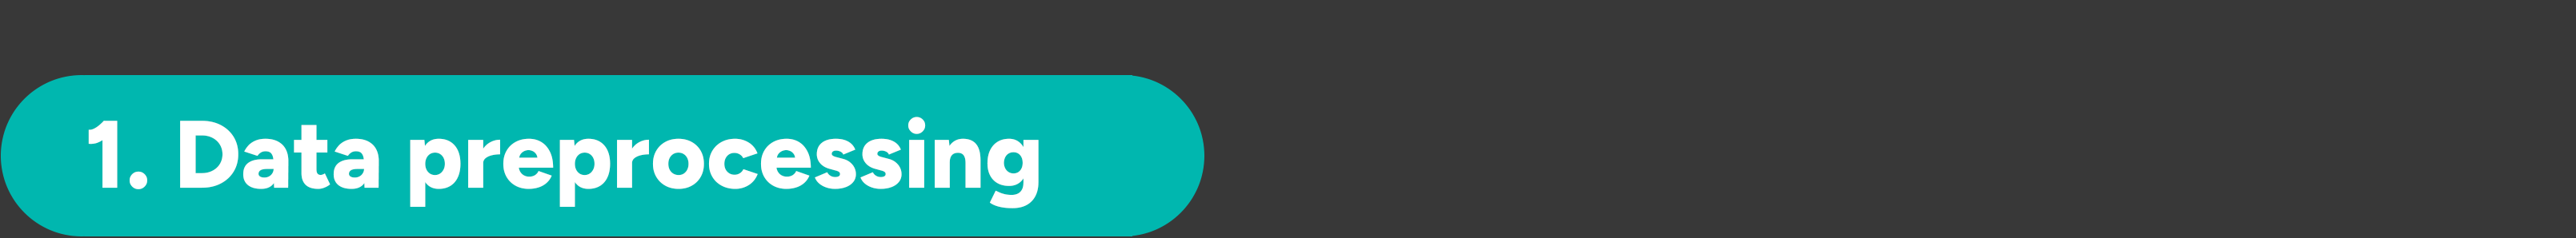

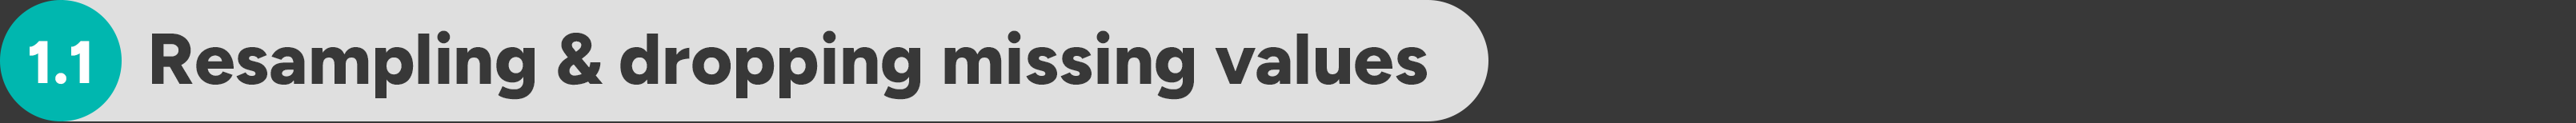

Resampling (5 min interval to daily interval) + dropping nans (for non trading days)

In [ ]:
forex_daily = forex.resample('D').mean()
forex_daily.dropna(inplace = True)
forex_daily

,NZDJPY,USDNOK,AUDJPY,GBPSGD,CADJPY,EURJPY,XAGUSD,AUDCHF
Date,,,,,,,,
2013-03-18,78.868826,5.790434,99.262391,1.884967,93.292261,123.700739,28.954870,0.984021
2013-03-19,78.514902,5.811537,98.808842,1.888079,92.990419,123.070242,28.906283,0.981480
2013-03-20,78.578057,5.834484,99.142725,1.890114,93.016902,123.387845,28.871717,0.981423
2013-03-21,79.167710,5.840223,99.279198,1.893798,93.104660,123.166794,29.031668,0.984902
2013-03-22,78.859048,5.823279,98.788456,1.898793,92.445386,122.543539,28.945592,0.984958
...,...,...,...,...,...,...,...,...
2024-05-02,91.842667,11.030503,101.196609,1.700319,112.853420,165.721609,26.531112,0.597146
2024-05-03,91.616701,10.913880,100.827510,1.696113,111.892904,164.429801,26.522653,0.597832
2024-05-05,92.095900,10.846253,101.322600,1.693584,111.973850,164.920150,26.559250,0.598583


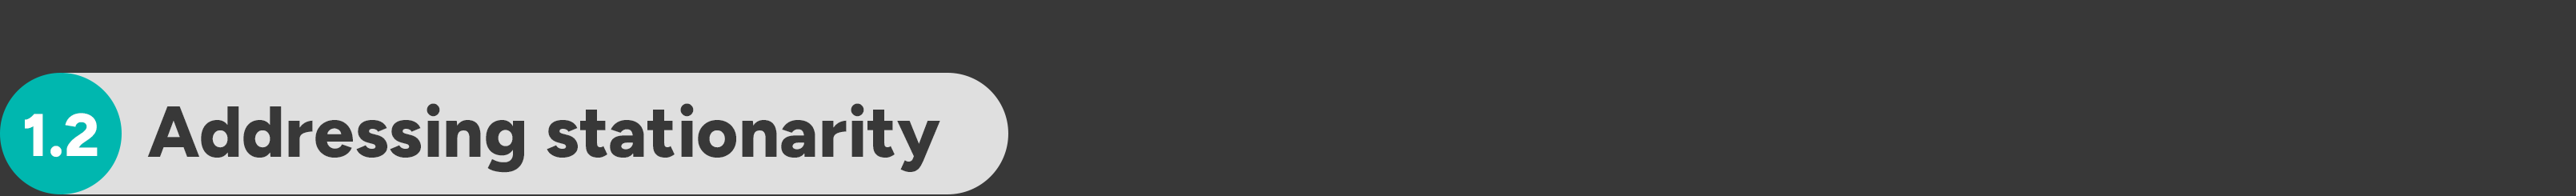

Stationarity is a necessary, non-sufficient condition for the high performance of an ML algorithm.

**PROBLEM**: there is a trade-off between stationarity and memory.
* too much differencing = stationary BUT no memory

**SOLUTION**: use fractional differencing, i.e. minimum degree of differencing, just enuf to pass adf test

Visual inspection

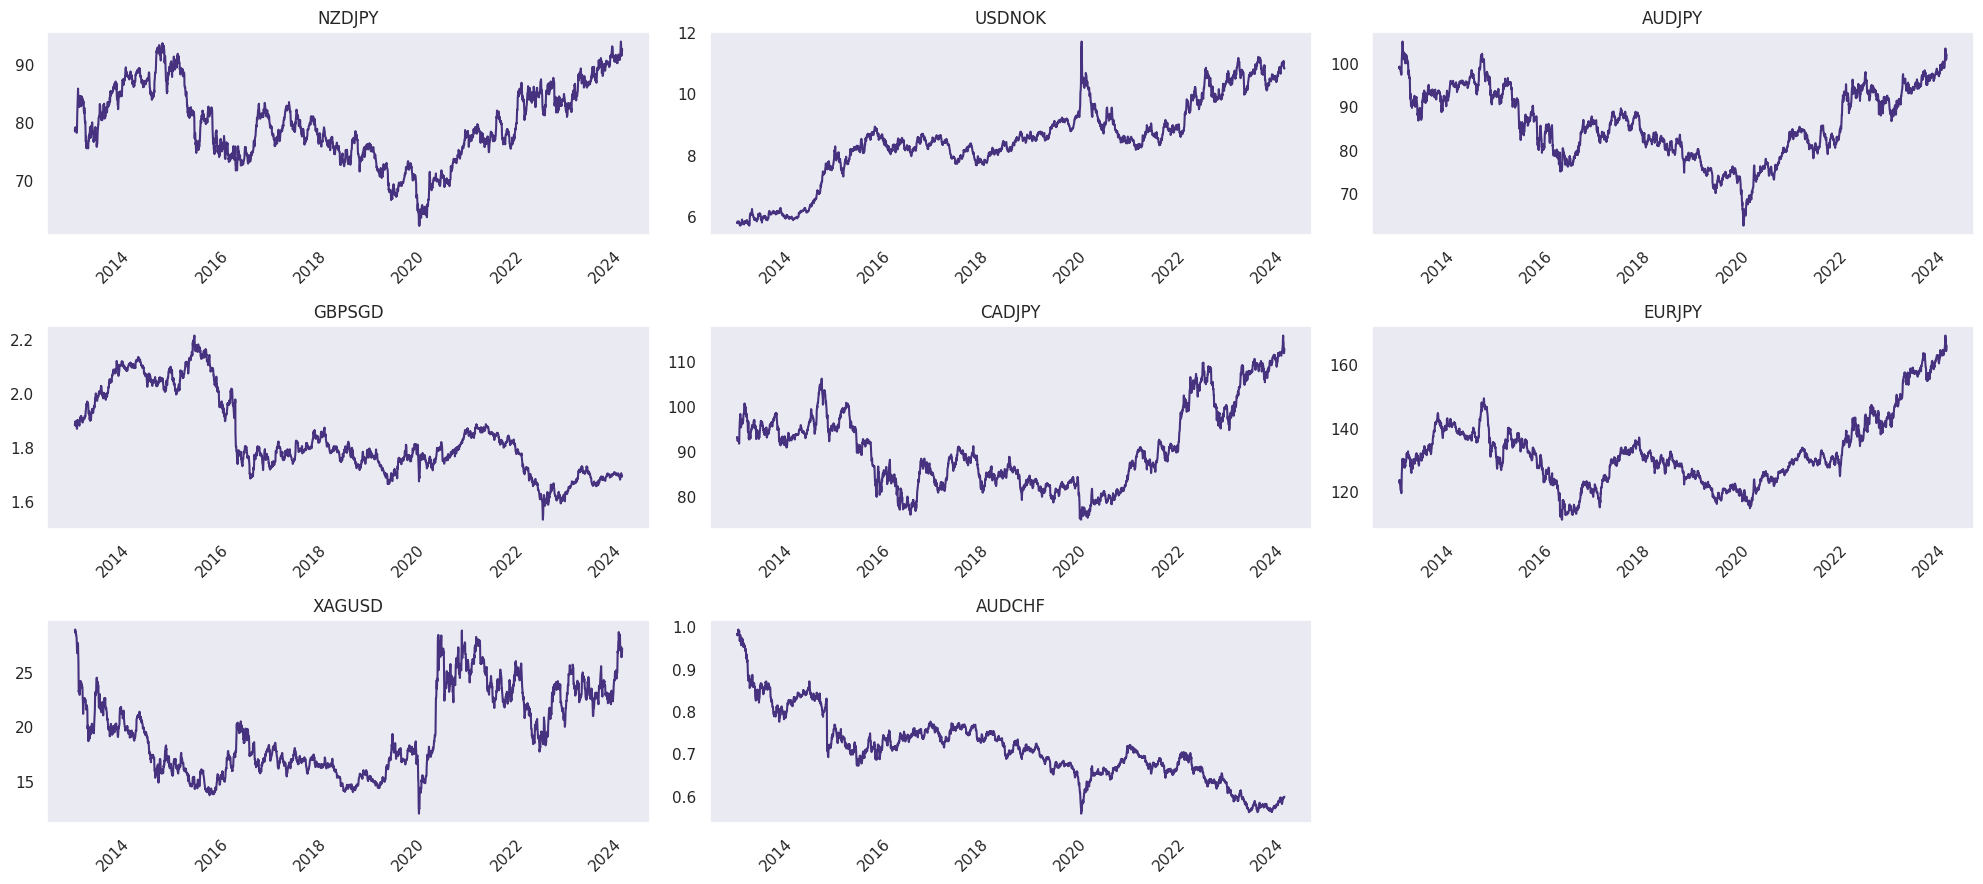

In [ ]:
num_plots = len(forex_daily.columns)
nrows = (num_plots // 3) + (1 if num_plots % 3 else 0)
ncols = min(3, num_plots)

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (20, 9))

axes = axes.flatten()

for i, column in enumerate(forex_daily.columns):
    axes[i].plot(forex_daily.index, forex_daily[column])
    axes[i].set_title(column)
    axes[i].tick_params(axis = "x", rotation = 45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

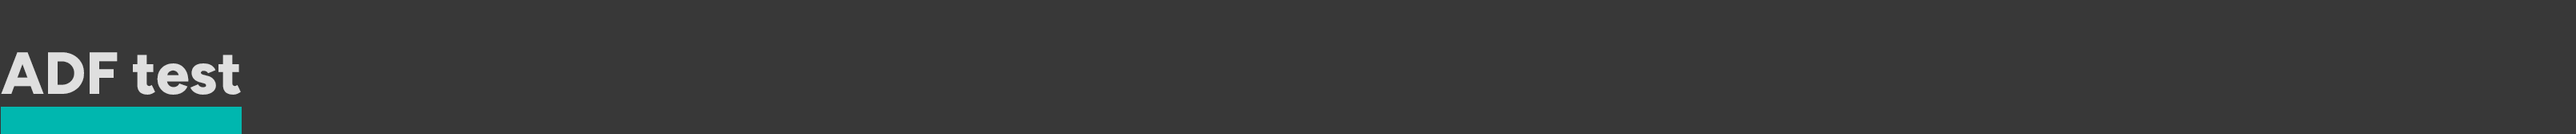

In [ ]:
adf_results = []
for pair in forex_daily.columns:
    result = adfuller(forex_daily[pair])
    adf_stat = result[0]
    p = result[1]
    adf_results.append((pair, adf_stat, p))

adf_results = pd.DataFrame(adf_results, columns = ['pair', 'adf_stat', 'p'])
display(adf_results)
print(f'\nNumber of pairs with a p-value < 0.05: {sum(adf_results.p < 0.05)} out of {len(adf_results)} pairs.')
adf_non_stationary = adf_results[adf_results["p"] < 0.05].reset_index(drop = True)
adf_non_stationary

,pair,adf_stat,p
0,NZDJPY,-1.763264,0.398847
1,USDNOK,-1.464127,0.551177
2,AUDJPY,-1.902124,0.331063
3,GBPSGD,-1.360763,0.600935
4,CADJPY,-0.940435,0.774365
5,EURJPY,-0.570026,0.877612
6,XAGUSD,-2.500256,0.115412
7,AUDCHF,-3.040725,0.031262



Number of pairs with a p-value < 0.05: 1 out of 8 pairs.


,pair,adf_stat,p
0,AUDCHF,-3.040725,0.031262


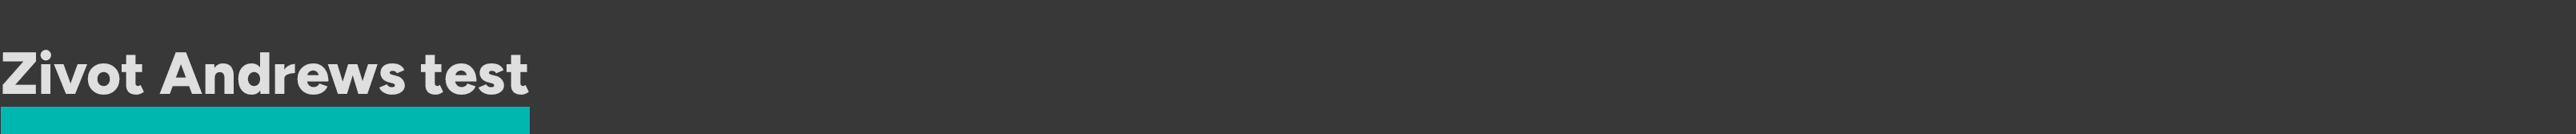

Address adf test's issue by accounting for single structural breaks

In [ ]:
from arch.unitroot import ZivotAndrews

za_results = []

for pair in forex_daily.columns:
    za = ZivotAndrews(forex_daily[pair])
    p = za.pvalue
    stat = za.stat
    za_results.append((pair, stat, p))

za_results = pd.DataFrame(za_results, columns = ['pair', 'za_stat', 'p'])
display(za_results)

print(f'\nNumber of pairs with a p-value < 0.05: {sum(za_results.p < 0.05)} out of {len(za_results)} pairs.')
za_non_stationary = za_results[za_results["p"] < 0.05].reset_index(drop = True)
za_non_stationary

,pair,za_stat,p
0,NZDJPY,-3.492986,0.684153
1,USDNOK,-3.823301,0.463739
2,AUDJPY,-3.599176,0.614633
3,GBPSGD,-4.579112,0.097066
4,CADJPY,-3.441184,0.716414
5,EURJPY,-3.298552,0.796055
6,XAGUSD,-6.037815,0.000786
7,AUDCHF,-4.816294,0.049369



Number of pairs with a p-value < 0.05: 2 out of 8 pairs.


,pair,za_stat,p
0,XAGUSD,-6.037815,0.000786
1,AUDCHF,-4.816294,0.049369


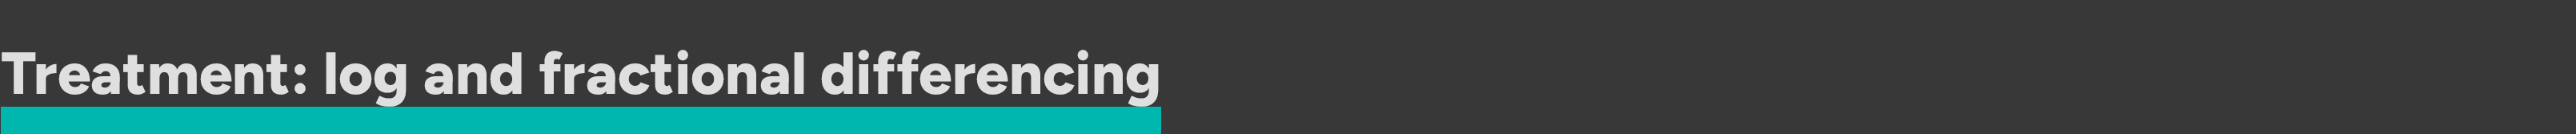

Source: textbook page 160, 161

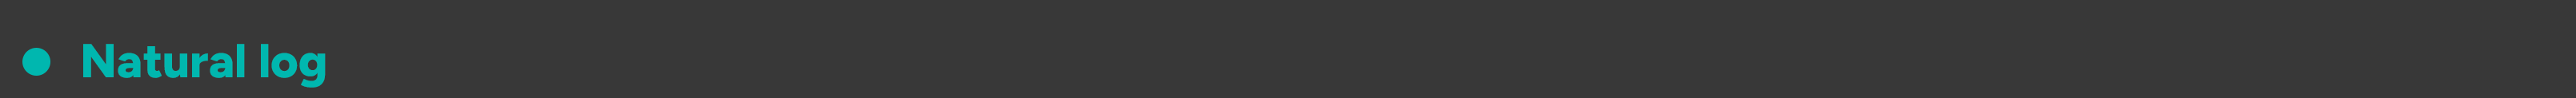

In [ ]:
forex_daily_log = np.log(forex_daily)
forex_daily_log.head(2)

,NZDJPY,USDNOK,AUDJPY,GBPSGD,CADJPY,EURJPY,XAGUSD,AUDCHF
Date,,,,,,,,
2013-03-18,4.367786,1.756207,4.597767,0.633911,4.535737,4.817865,3.365738,-0.016108
2013-03-19,4.363288,1.759845,4.593187,0.635560,4.532496,4.812755,3.364059,-0.018693


Since the values of AUDCHF is too close to zero -> negative log prices. Fix: **translation** - adding a constant to value b4 taking log.

In [ ]:
a = 1 - np.min(forex_daily)
forex_daily_log = np.log(forex_daily + a)
forex_daily_log

,NZDJPY,USDNOK,AUDJPY,GBPSGD,CADJPY,EURJPY,XAGUSD,AUDCHF
Date,,,,,,,,
2013-03-18,4.373354,1.829510,4.602194,0.843877,4.540447,4.821419,3.380834,0.353764
2013-03-19,4.368882,1.832891,4.597634,0.845214,4.537221,4.816327,3.379179,0.351979
2013-03-20,4.369681,1.836555,4.600993,0.846088,4.537505,4.818895,3.378001,0.351938
2013-03-21,4.377116,1.837469,4.602362,0.847667,4.538443,4.817109,3.383443,0.354382
2013-03-22,4.373231,1.834767,4.597429,0.849805,4.531371,4.812054,3.380518,0.354421
...,...,...,...,...,...,...,...,...
2024-05-02,4.524861,2.439813,4.621408,0.761141,4.729985,5.112963,3.294781,0.036857
2024-05-03,4.522409,2.429595,4.617770,0.759174,4.721470,5.105158,3.294467,0.037517
2024-05-05,4.527601,2.423621,4.622647,0.757989,4.722191,5.108128,3.295824,0.038241


Checking to see if logging has stabilise the data enuf:

In [ ]:
logged_adf_results = []
for pair in forex_daily.columns:
    result = adfuller(forex_daily_log[pair])
    logged_adf_stat = result[0]
    p = result[1]
    logged_adf_results.append((pair, logged_adf_stat, p))

logged_adf_results = pd.DataFrame(logged_adf_results, columns = ['pair', 'logged_adf_stat', 'p'])
display(logged_adf_results)
print(f'\nNumber of pairs with a p-value < 0.05: {sum(logged_adf_results.p < 0.05)} out of {len(logged_adf_results)} pairs.')
logged_adf_non_stationary = logged_adf_results[logged_adf_results["p"] < 0.05].reset_index(drop = True)

,pair,logged_adf_stat,p
0,NZDJPY,-1.806619,0.377180
1,USDNOK,-1.687895,0.437360
2,AUDJPY,-1.919301,0.323037
3,GBPSGD,-1.390507,0.586819
4,CADJPY,-1.083458,0.721624
5,EURJPY,-0.835126,0.808586
6,XAGUSD,-2.593450,0.094359
7,AUDCHF,-2.737852,0.067714



Number of pairs with a p-value < 0.05: 0 out of 8 pairs.


Cos it's pretty much stationary now -> no need for frac diff (that is if we use ADF fuller test result as a benchmark)

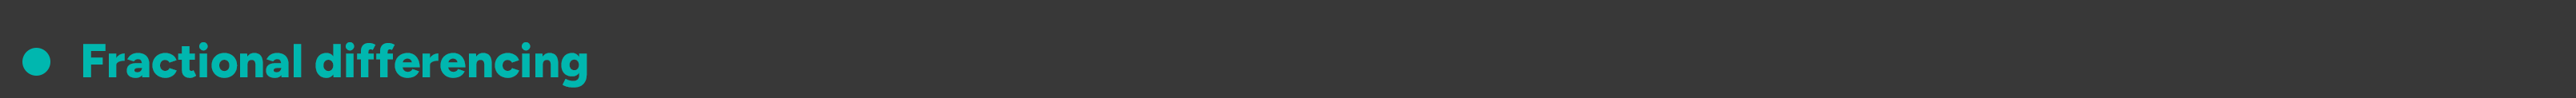

might delete later

In [ ]:
frac_diff_price_df = forex_daily_log.copy()
fracDiff = FractionalDifferentiator()

for pair in logged_adf_non_stationary.pair.values[:]:
    frac_diff_price_df[pair] = fracDiff.FitTransform(forex_daily[pair])
display(frac_diff_price_df)

nan_counts = frac_diff_price_df.isnull().sum()
columns_with_nans = [nan_counts[nan_counts > 0]]
print("Number of columns with NaN values:")
columns_with_nans

,NZDJPY,USDNOK,AUDJPY,GBPSGD,CADJPY,EURJPY,XAGUSD,AUDCHF
Date,,,,,,,,
2013-03-18,4.373354,1.829510,4.602194,0.843877,4.540447,4.821419,3.380834,0.353764
2013-03-19,4.368882,1.832891,4.597634,0.845214,4.537221,4.816327,3.379179,0.351979
2013-03-20,4.369681,1.836555,4.600993,0.846088,4.537505,4.818895,3.378001,0.351938
2013-03-21,4.377116,1.837469,4.602362,0.847667,4.538443,4.817109,3.383443,0.354382
2013-03-22,4.373231,1.834767,4.597429,0.849805,4.531371,4.812054,3.380518,0.354421
...,...,...,...,...,...,...,...,...
2024-05-02,4.524861,2.439813,4.621408,0.761141,4.729985,5.112963,3.294781,0.036857
2024-05-03,4.522409,2.429595,4.617770,0.759174,4.721470,5.105158,3.294467,0.037517
2024-05-05,4.527601,2.423621,4.622647,0.757989,4.722191,5.108128,3.295824,0.038241


Number of columns with NaN values:


[Series([], dtype: int64)]

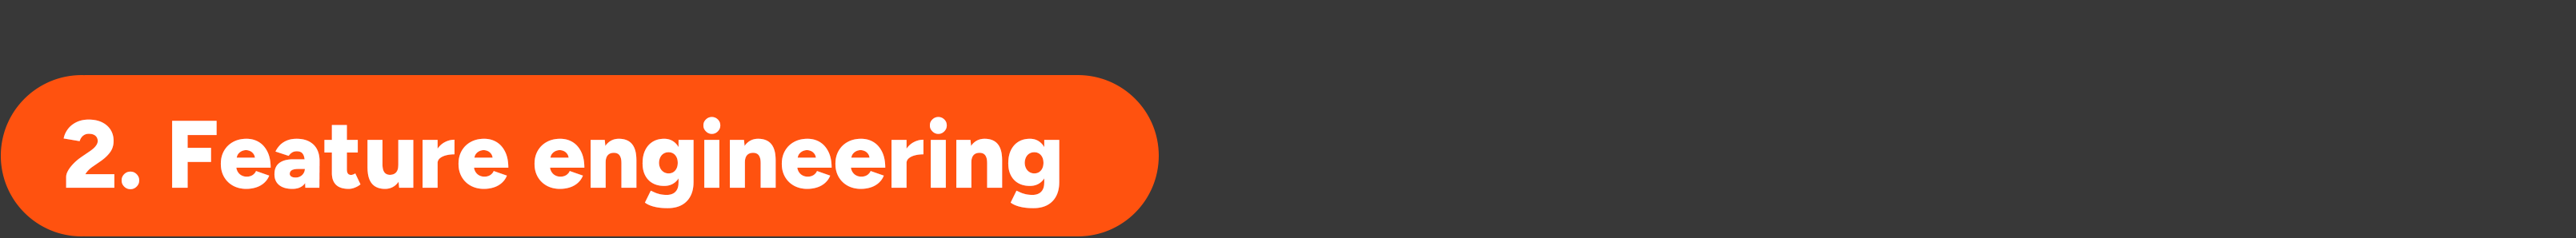

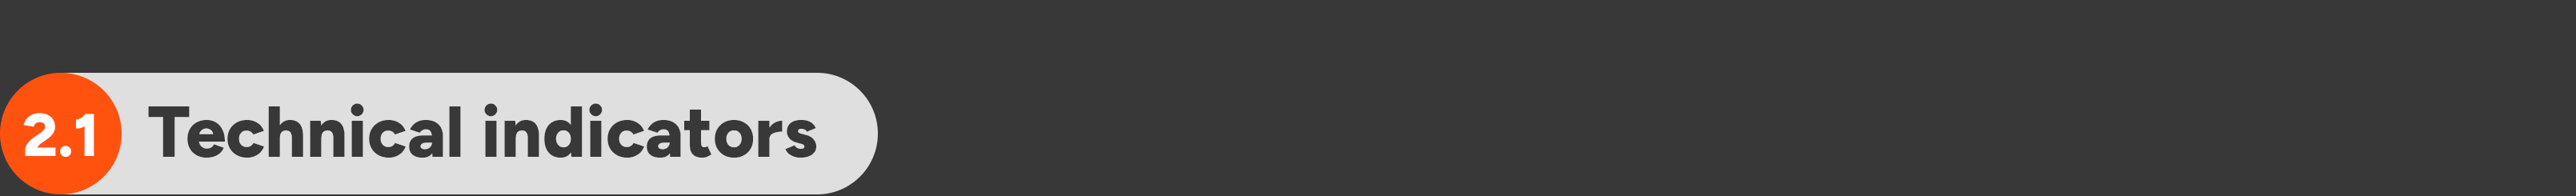

Lets just pick out AUDCHF as an example to see how the `features` df is formed for each price path.

In [ ]:
# Pick out a single path to demonstrate how the features df is created
AUDCHF = forex_daily['AUDCHF']
features_AUDCHF = pd.DataFrame()

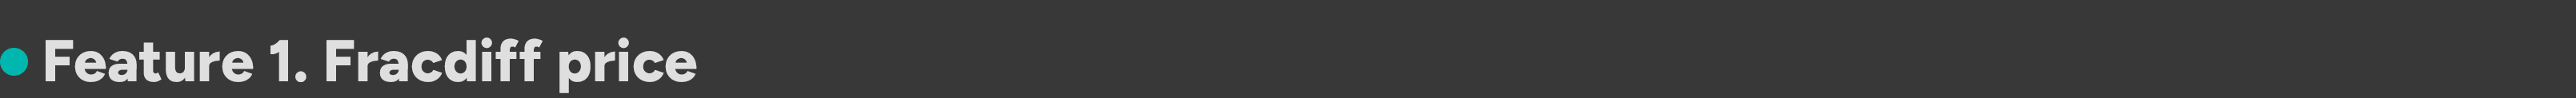

will delete later

In [ ]:
features_AUDCHF['frac_diff'] = frac_diff_price_df['AUDCHF']

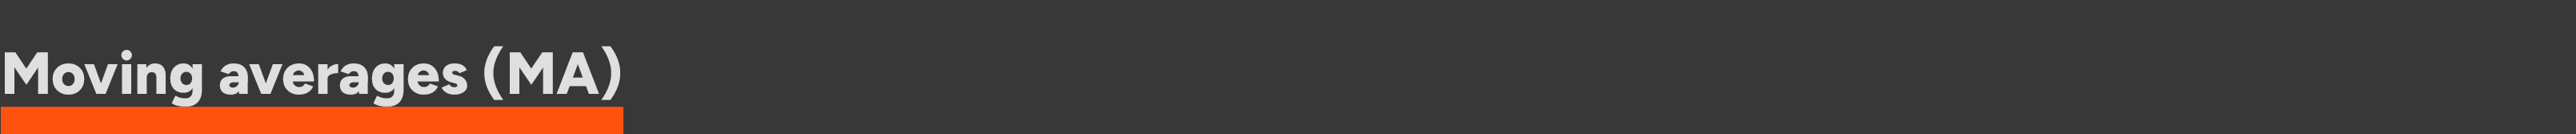

Simple moving average (sma), exponential moving average (ema)

Consider: integrated window moving average (iwma)

In [ ]:
features_AUDCHF['sma_10'] = ta.trend.sma_indicator(AUDCHF, window=10)
features_AUDCHF['sma_20'] = ta.trend.sma_indicator(AUDCHF, window=20)

features_AUDCHF['ema_10'] = ta.trend.ema_indicator(AUDCHF, window=10)
features_AUDCHF['ema_20'] = ta.trend.ema_indicator(AUDCHF, window=20)

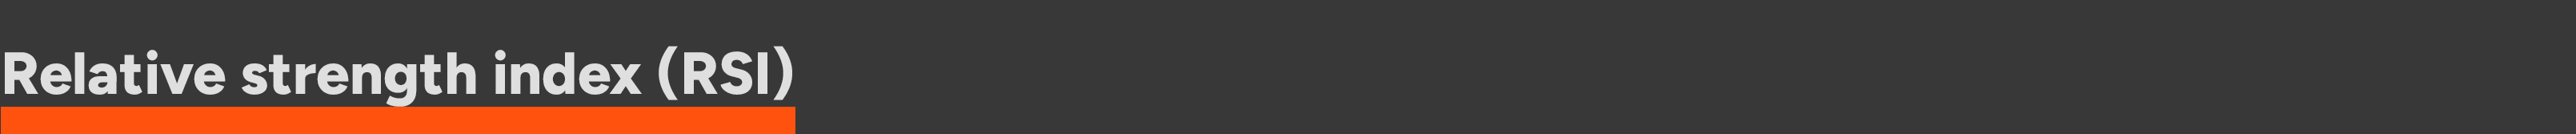

In [ ]:
features_AUDCHF['rsi'] = ta.momentum.rsi(AUDCHF)
features_AUDCHF['macd'] = ta.trend.macd_diff(AUDCHF)
features_AUDCHF['bb_upper'], features_AUDCHF['bb_middle'], features_AUDCHF['bb_lower'] = \
    ta.volatility.bollinger_hband_indicator(AUDCHF), ta.volatility.bollinger_mavg(AUDCHF), \
    ta.volatility.bollinger_lband_indicator(AUDCHF)

Normalisation of features

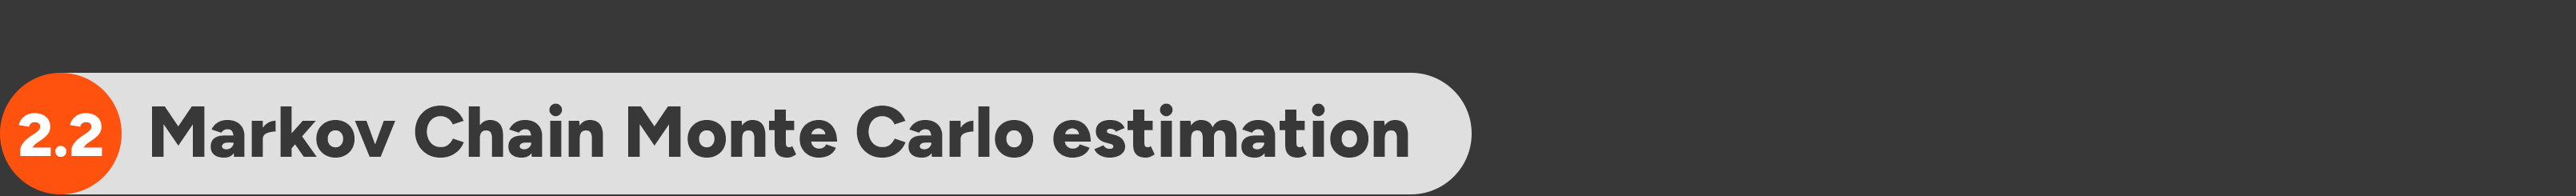

To do
1. Define regimes
2. Create transitn matrix and calibrate inistial and trans probability
3. Simulate

**Types of Regime Switching Models**
1. Markov Switching Autoregressive Model (MS-AR)

2. Markov Switching Vector Autoregressive Model (MS-VAR)

3. Markov Switching GARCH Model (MS-GARCH)

**Estimation**
1. Maximum Likelihood Estimation (MLE)

* most common
2. Expectation-Maximisation (EM)
* E: algorithm calculates the expected value of the complete data log-likelihood, given the observed data and current parameter estimates (State Probabilities & Expected Log-Likelihood)
* M: maximises the expected log-likelihood obtained from the E-step; Update / re-estimate the parameters (e.g., transition probabilities, state-specific means, and variances) to maximise the expected log-likelihood. Iterate until the changes in parameter estimates are sufficiently small, indicating convergence.

3. Baum-Welch algorithm
* specific instance of the EM algorithm used for Hidden Markov Models (HMMs)

**THIS ONE = BAUM WELCH**


In [ ]:
def fit_hmm(data):
    if isinstance(data, pd.DataFrame):
        data = data.values

    model = hmm.GaussianHMM(n_components = 2, covariance_type = "full")
    model.fit(data)

    hidden_states = model.predict(data)
    state_probs = model.predict_proba(data)
    means = model.means_.flatten()
    variances = [np.sqrt(np.diag(cov)) for cov in model.covars_]

    state_params = pd.DataFrame({
        'State': range(len(means)),
        'Mean': means,
        'Variance': [var[0] for var in variances]
    })

    state_probs_df = pd.DataFrame(state_probs, columns=[f'Probability of state {i}' for i in range(state_probs.shape[1])])

    result_df = pd.DataFrame(data, columns=['Value'])
    result_df = pd.concat([result_df, state_probs_df], axis=1)

    fig, axs = plt.subplots(1, 2, figsize=(12, 3))

    sns.lineplot(data=pd.DataFrame({'index': range(len(state_probs[:, 1])), 'Probability': state_probs[:, 1]}), x='index', y='Probability', ax=axs[0])
    axs[0].set_title('Probability of State 1')

    sns.lineplot(data=pd.DataFrame(data, columns=['Value']).reset_index(), x='index', y='Value', ax=axs[1])
    axs[1].set_title('Original Data')

    plt.tight_layout()

    return result_df, state_params

,Value,Probability of state 0,Probability of state 1
0,0.984021,2.011334e-80,1.000000e+00
1,0.981480,8.545740e-22,1.000000e+00
2,0.981423,8.566584e-22,1.000000e+00
3,0.984902,7.396100e-22,1.000000e+00
4,0.984958,7.378690e-22,1.000000e+00
...,...,...,...
3440,0.597146,1.000000e+00,2.507360e-22
3441,0.597832,1.000000e+00,2.646311e-22
3442,0.598583,1.000000e+00,2.807554e-22
3443,0.599681,1.000000e+00,3.070411e-22


,State,Mean,Variance
0,0,0.686769,0.054321
1,1,0.848881,0.048028


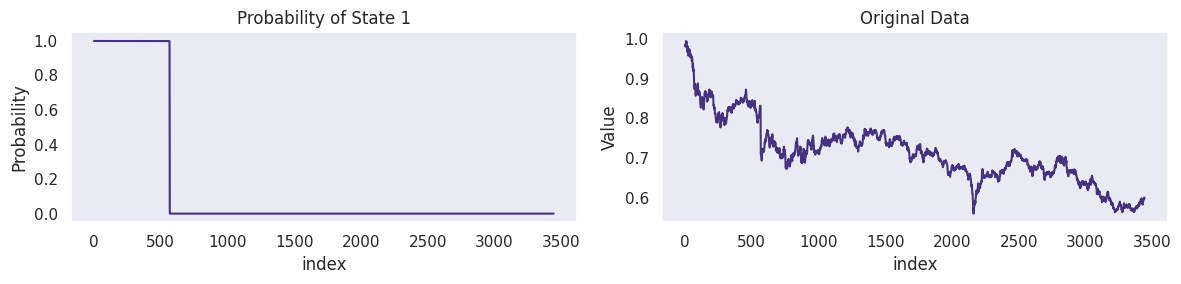

In [ ]:
result_df, state_params = fit_hmm(forex_daily[['AUDCHF']])

display(result_df)
display(state_params)

In [ ]:
result_df.iloc[:, 1]

0       2.011334e-80
1       8.545740e-22
2       8.566584e-22
3       7.396100e-22
4       7.378690e-22
            ...     
3440    1.000000e+00
3441    1.000000e+00
3442    1.000000e+00
3443    1.000000e+00
3444    1.000000e+00
Name: Probability of state 0, Length: 3445, dtype: float64

In [ ]:
features_AUDCHF['prob_state_0'] = result_df.iloc[:, 1]
features_AUDCHF['prob_state_1'] = result_df.iloc[:, 2]
features_AUDCHF

,frac_diff,sma_10,sma_20,ema_10,ema_20,rsi,macd,bb_upper,bb_middle,bb_lower,prob_state_0,prob_state_1
Date,,,,,,,,,,,,
2013-03-18,0.353764,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN
2013-03-19,0.351979,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN
2013-03-20,0.351938,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN
2013-03-21,0.354382,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN
2013-03-22,0.354421,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-02,0.036857,0.594561,0.591751,0.594756,0.592763,61.995663,0.000559,0.0,0.591751,0.0,NaN,NaN
2024-05-03,0.037517,0.595661,0.591813,0.595315,0.593246,63.097856,0.000530,0.0,0.591813,0.0,NaN,NaN
2024-05-05,0.038241,0.596591,0.592002,0.595909,0.593754,64.320930,0.000513,0.0,0.592002,0.0,NaN,NaN


,Value,Probability of state 0,Probability of state 1
0,0.353764,1.000000,6.637678e-22
1,0.351979,0.998236,1.763631e-03
2,0.351938,0.998234,1.766307e-03
3,0.354382,0.998410,1.589580e-03
4,0.354421,0.998413,1.586870e-03
...,...,...,...
3440,0.036857,0.796619,2.033811e-01
3441,0.037517,0.795484,2.045163e-01
3442,0.038241,0.794263,2.057373e-01
3443,0.039296,0.792433,2.075675e-01


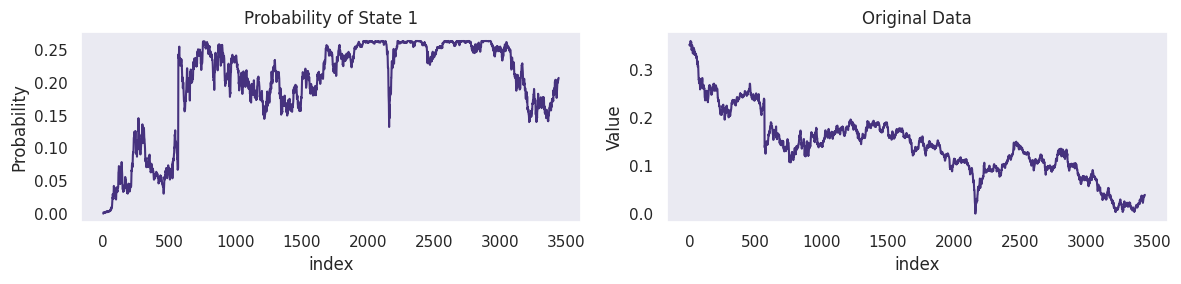

In [ ]:
pair = 'AUDCHF'
price = forex_daily_log[[pair]]
result_df, state_params = fit_hmm(price)
result_df

In [ ]:

prob_0 = result_df.iloc[:, 1]
prob_1 = result_df.iloc[:, 2]
prob_0

0       1.000000
1       0.998236
2       0.998234
3       0.998410
4       0.998413
          ...   
3440    0.796619
3441    0.795484
3442    0.794263
3443    0.792433
3444    0.792277
Name: Probability of state 0, Length: 3445, dtype: float64

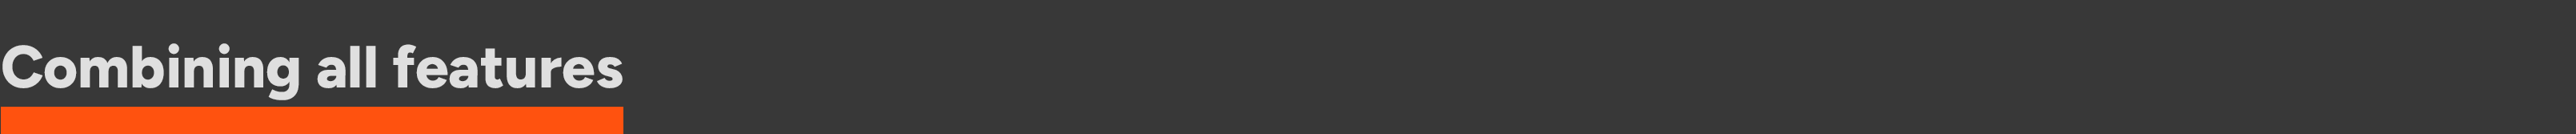

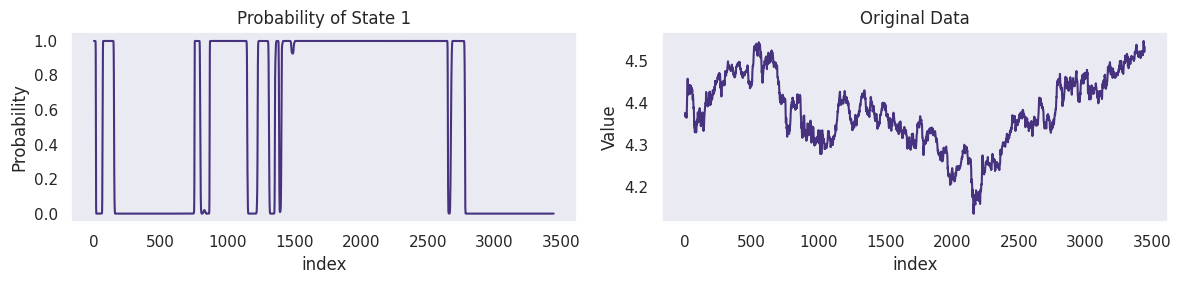

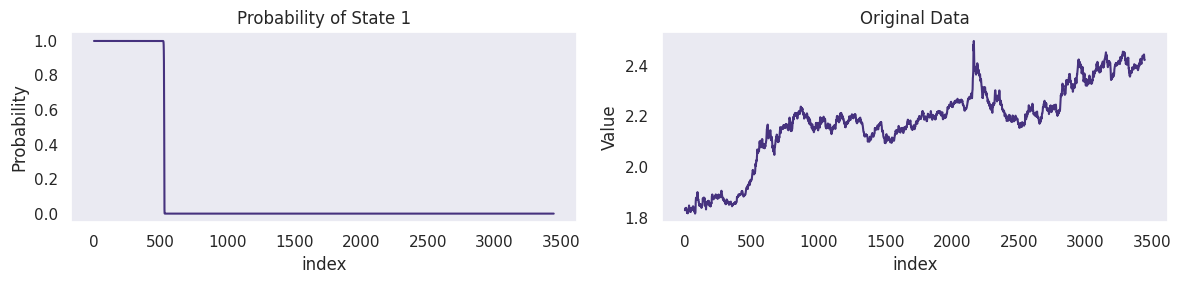

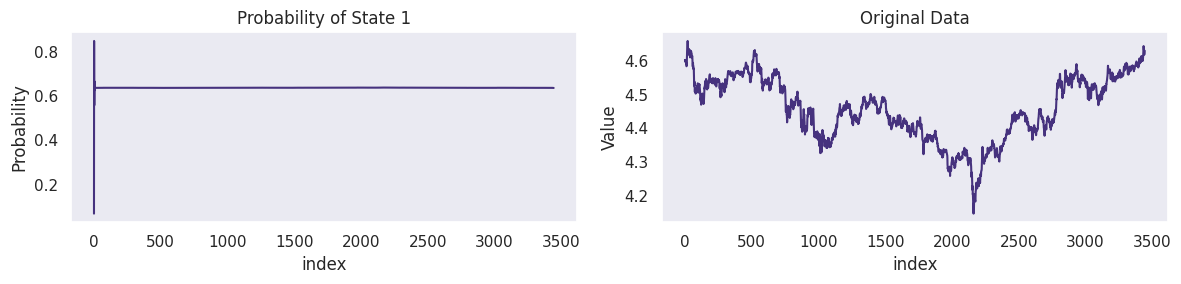

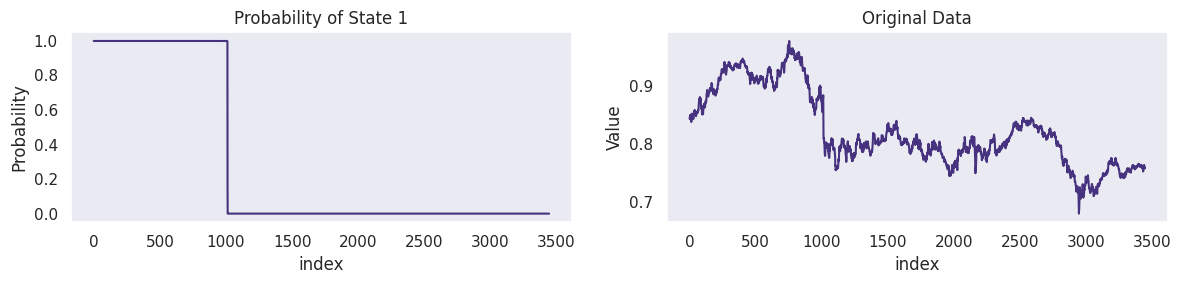

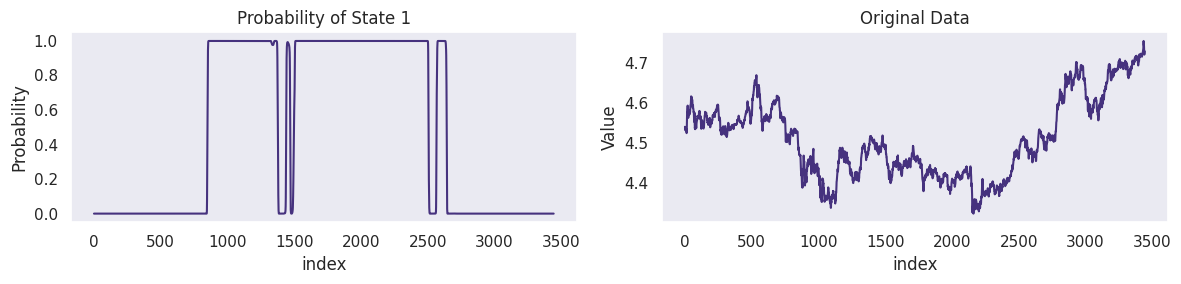

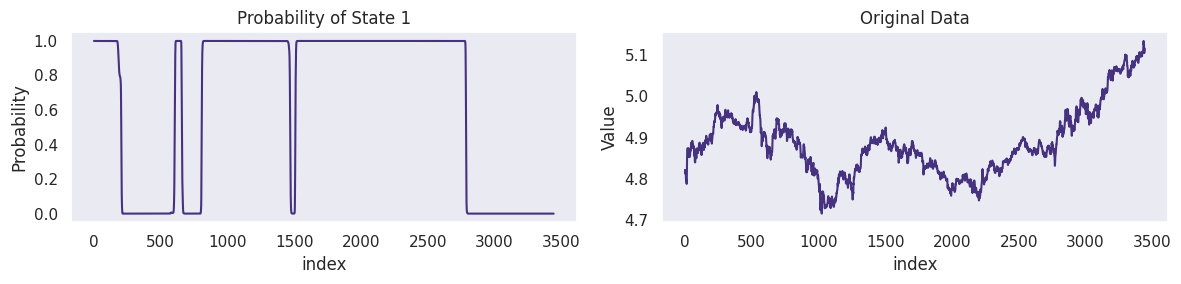

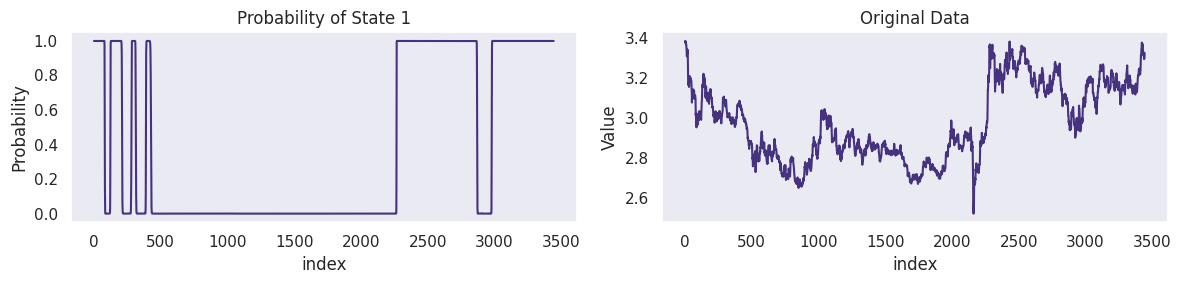

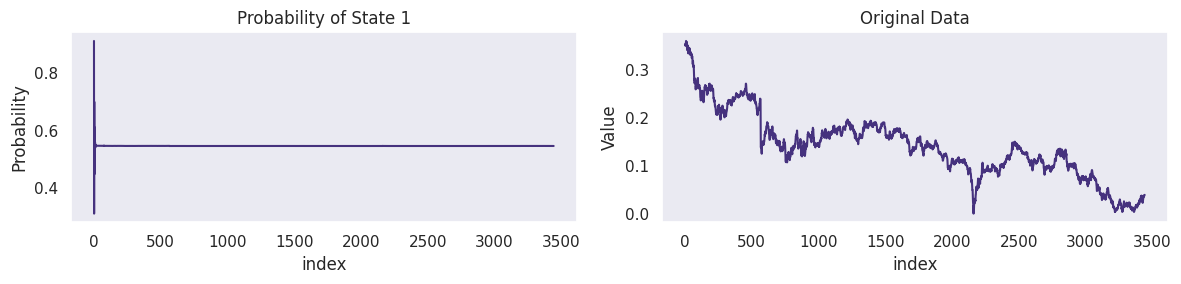

In [ ]:
for pair in forex_daily_log.columns:
    features = pd.DataFrame()
    price = forex_daily_log[pair]

    features['frac_diff'] = frac_diff_price_df[pair]
    features['sma_10'] = ta.trend.sma_indicator(price, window=10)
    features['sma_20'] = ta.trend.sma_indicator(price, window=20)
    features['ema_10'] = ta.trend.ema_indicator(price, window=10)
    features['ema_20'] = ta.trend.ema_indicator(price, window=20)
    hmm_result_df, _ = fit_hmm(price.values.reshape(-1, 1))

    features['prob_0'] = (hmm_result_df.iloc[:, 1]).values
    features['prob_1'] = (hmm_result_df.iloc[:, 2]).values

    features['rsi'] = ta.momentum.rsi(price)
    features['macd'] = ta.trend.macd_diff(price)
    features['bb_upper'] = ta.volatility.bollinger_hband(price)
    features['bb_middle'] = ta.volatility.bollinger_mavg(price)
    features['bb_lower'] = ta.volatility.bollinger_lband(price)

In [ ]:
features

,frac_diff,sma_10,sma_20,ema_10,ema_20,prob_0,prob_1,rsi,macd,bb_upper,bb_middle,bb_lower
Date,,,,,,,,,,,,
2013-03-18,0.353764,NaN,NaN,NaN,NaN,0.089074,0.910926,NaN,NaN,NaN,NaN,NaN
2013-03-19,0.351979,NaN,NaN,NaN,NaN,0.688246,0.311754,NaN,NaN,NaN,NaN,NaN
2013-03-20,0.351938,NaN,NaN,NaN,NaN,0.299956,0.700044,NaN,NaN,NaN,NaN,NaN
2013-03-21,0.354382,NaN,NaN,NaN,NaN,0.551577,0.448423,NaN,NaN,NaN,NaN,NaN
2013-03-22,0.354421,NaN,NaN,NaN,NaN,0.388458,0.611542,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-02,0.036857,0.034355,0.031631,0.034542,0.032610,0.453489,0.546511,61.991346,0.000540,0.041220,0.031631,0.022043
2024-05-03,0.037517,0.035421,0.031691,0.035083,0.033078,0.453503,0.546497,63.086686,0.000511,0.041410,0.031691,0.021972
2024-05-05,0.038241,0.036320,0.031873,0.035657,0.033569,0.453498,0.546502,64.301826,0.000495,0.041933,0.031873,0.021813


In [ ]:
features.isna().sum()

frac_diff     0
sma_10        9
sma_20       19
ema_10        9
ema_20       19
prob_0        0
prob_1        0
rsi          13
macd         33
bb_upper     19
bb_middle    19
bb_lower     19
dtype: int64

<div class="alert alert-info">

## <b>2. Strategy development</b>

</div>

Technical indicators

In [ ]:
import ta

In [ ]:
forex

,NZDJPY,USDNOK,AUDJPY,GBPSGD,CADJPY,EURJPY,XAGUSD,AUDCHF
Date,,,,,,,,
2013-03-18 22:05:00,78.817,5.79210,99.159,1.88498,93.246,123.528,28.950,0.98401
2013-03-18 22:10:00,78.815,5.79153,99.167,1.88536,93.245,123.507,28.947,0.98431
2013-03-18 22:15:00,78.810,5.79213,99.157,1.88551,93.231,123.536,28.956,0.98440
2013-03-18 22:20:00,78.822,5.79259,99.182,1.88563,93.206,123.531,28.970,0.98448
2013-03-18 22:25:00,78.853,5.79234,99.229,1.88564,93.179,123.589,28.963,0.98445
...,...,...,...,...,...,...,...,...
2024-05-07 10:05:00,92.828,10.86585,101.990,1.69644,112.977,166.347,27.204,0.59906
2024-05-07 10:10:00,92.822,10.86554,101.995,1.69645,112.965,166.364,27.205,0.59900
2024-05-07 10:15:00,92.828,10.86469,102.016,1.69645,112.973,166.376,27.194,0.59904


<div class="alert alert-info">

## <b>3. Strategy backtesting</b>

</div>

<div class="alert alert-info">

## <b>4. Evaluating backtest overfitting</b>

</div>